In [49]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import codecs

dirname = '张学良'
# dirname = '文章'
train = []

fp=codecs.open(f'{dirname}/全文分词.txt','r',encoding='UTF-8')
data=fp.read()
fp.close()
print('finish')

finish


In [50]:
from collections import defaultdict
texts = data.split()
text_dic = defaultdict(int)
for word in texts:
    text_dic[word] += 1

# 去除低频词
# low_freq_words = [word for word, freq in text_dic.items() if freq < 5]
# high_freq_words = [word for word, freq in text_dic.items() if freq >= 3]

# 读取文档
with open(f'{dirname}/全文分词.txt', 'r') as f:
    docs = [[word for word in line.strip().split() if text_dic[word]] for line in f]

In [51]:
from gensim.models import Phrases
# 向文档中添加双字母组和三字母组（仅出现10次或以上的文档）。
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])
 
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # token是一个二元组，添加到文档中。
            docs[idx].append(token)

In [54]:
# 创建词典
dictionary = corpora.Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

dictionary.filter_extremes(no_below=3, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 8883
Number of unique words after removing rare and common words: 1453


In [63]:
# 创建语料库
corpus = [dictionary.doc2bow(document) for document in docs]

# 训练LDA模型
# lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=2)
lda_model = LdaModel(corpus=corpus, id2word=dictionary, \
                    alpha='auto', eta='auto', \
                    iterations=100, num_topics=3, \
                    passes=1, eval_every=5)

# 打印所有主题
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# 打印每个文档的主题分布
for i, topics in enumerate(lda_model[corpus]):
    print('Document {} \nTopics: {}'.format(i, topics))

Topic: 0 
Words: 0.023*"张学良" + 0.012*"事情" + 0.012*"张学良_口述" + 0.012*"中国" + 0.012*"历史" + 0.011*"北京_中国" + 0.011*"历史_唐德刚" + 0.011*"档案_出版社" + 0.010*"北京" + 0.009*"蒋先生"
Topic: 1 
Words: 0.016*"父亲" + 0.010*"日本" + 0.009*"中国" + 0.008*"东北" + 0.008*"少帅" + 0.008*"历史" + 0.007*"奉天" + 0.006*"喜欢" + 0.006*"事情" + 0.006*"口述_历史"
Topic: 2 
Words: 0.029*"父亲" + 0.009*"事情" + 0.008*"日本" + 0.007*"两个" + 0.007*"唐德刚" + 0.006*"东北" + 0.006*"告诉" + 0.006*"中国" + 0.006*"奉军" + 0.006*"军队"
Document 0 
Topics: [(0, 0.17502236), (1, 0.6650487), (2, 0.15992892)]
Document 1 
Topics: [(0, 0.6767018), (1, 0.1422039), (2, 0.18109432)]
Document 2 
Topics: [(0, 0.9963945)]
Document 3 
Topics: [(0, 0.9704486), (1, 0.013943743), (2, 0.015607633)]
Document 4 
Topics: [(0, 0.8041431), (1, 0.092780836), (2, 0.10307612)]
Document 5 
Topics: [(0, 0.67659616), (1, 0.14220455), (2, 0.18119925)]
Document 6 
Topics: [(0, 0.98181427)]
Document 7 
Topics: [(0, 0.96494746), (1, 0.016549762), (2, 0.018502777)]
Document 8 
Topics: [(0, 0.80131626),

In [64]:
d=pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(d, 'lda.html')

In [60]:
import numpy as np
from gensim.models.coherencemodel import CoherenceModel

best_num_topics = None
best_perplexity = float('inf')
x_index = range(2, 20)
perplexity_mean = []
perplexity_std = []
coherence_mean = []
coherence_std = []

# 计算每个num_topics下的perplexity并选择最佳参数
for num_topics in x_index:

    perplexity_list = []
    coherence_list = []
    for i in range(3):
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=2)
        perplexity = -lda_model.log_perplexity(corpus)
        perplexity_list.append(perplexity)

        coherence_model = CoherenceModel(model=lda_model, corpus=corpus, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_list.append(coherence_score)
    
    perplexity_mean.append(np.mean(perplexity_list))
    perplexity_std.append(np.std(perplexity_list))
    coherence_mean.append(np.mean(coherence_list))
    coherence_std.append(np.std(coherence_list))
    
    print('Number of Topics: {}, Perplexity: {} ± {}'.format(num_topics, np.mean(perplexity_list), np.std(perplexity_list)))
    print('Number of Topics: {}, Coherence Score: {} ± {}'.format(num_topics, np.mean(coherence_list), np.std(coherence_list)))


Number of Topics: 2, Perplexity: 6.901560124937338 ± 0.024332568052008206
Number of Topics: 2, Coherence Score: 0.2604585925840313 ± 0.07437084573280703
Number of Topics: 3, Perplexity: 6.935641408113632 ± 0.04557779195762378
Number of Topics: 3, Coherence Score: 0.3811162053713244 ± 0.021982434493465017
Number of Topics: 4, Perplexity: 6.996000898412848 ± 0.022214267982199595
Number of Topics: 4, Coherence Score: 0.3489388391987893 ± 0.03226608413824023
Number of Topics: 5, Perplexity: 7.011598147197614 ± 0.02440055612442159
Number of Topics: 5, Coherence Score: 0.3410334980053909 ± 0.007456043648524298
Number of Topics: 6, Perplexity: 7.05477635532143 ± 0.01967387572398412
Number of Topics: 6, Coherence Score: 0.3496128297684706 ± 0.01284599677141003
Number of Topics: 7, Perplexity: 7.113634204029661 ± 0.024289482551040076
Number of Topics: 7, Coherence Score: 0.35626280262657395 ± 0.01761600706432038
Number of Topics: 8, Perplexity: 7.137559344871032 ± 0.02569795097456796
Number of 

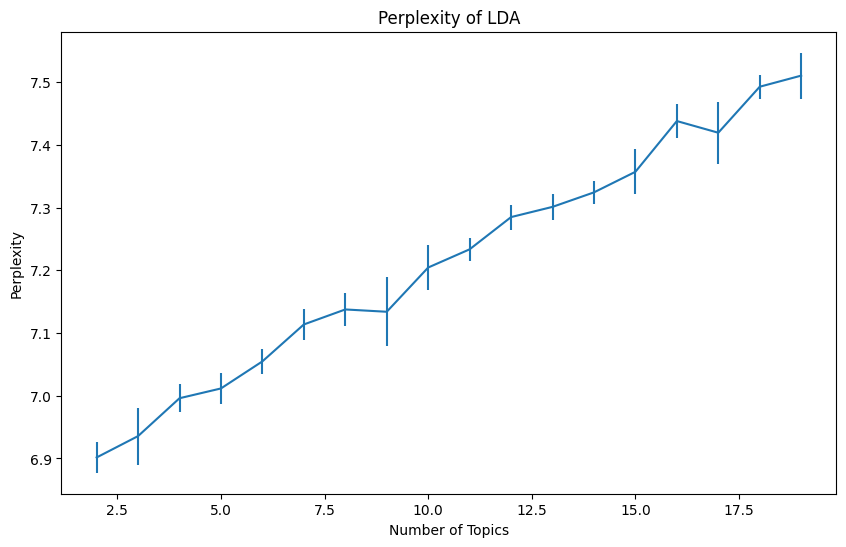

In [61]:
# draw a curve  for perplexity_mean and use perplexity_std to draw error bar
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.errorbar(x_index, perplexity_mean, yerr=perplexity_std)
plt.title('Perplexity of LDA')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.show()


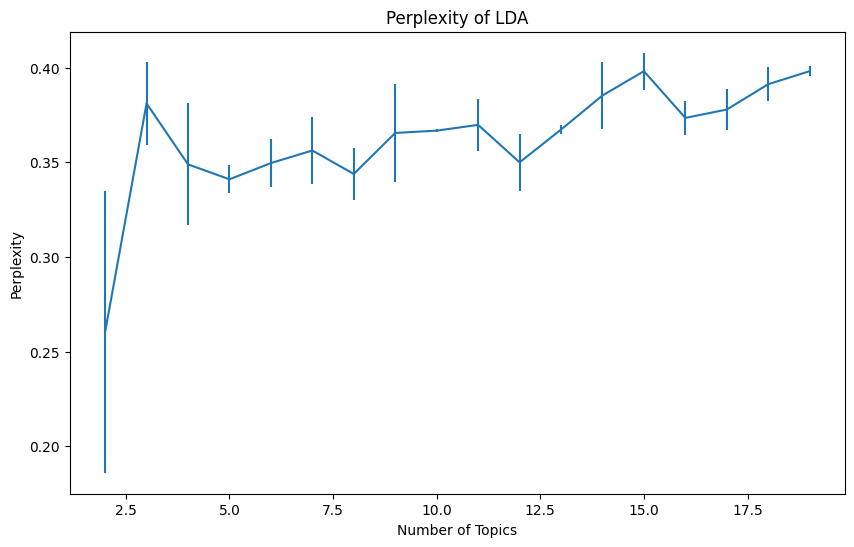

In [62]:
# draw a curve  for perplexity_mean and use perplexity_std to draw error bar
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.errorbar(x_index, coherence_mean, yerr=coherence_std)
plt.title('Perplexity of LDA')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.show()


In [17]:
for topic in lda_model.print_topics(num_words = 20):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')
print('finish')

0:
  "学校" (0.010)
  "学习" ( 0.010)
  "老师" ( 0.009)
  "说" ( 0.008)
  "讲" ( 0.007)
  "苏联" ( 0.006)
  "情况" ( 0.005)
  "两个" ( 0.005)
  "走" ( 0.004)
  "几个" ( 0.004)
  "中" ( 0.004)
  "做" ( 0.004)
  "图书馆学" ( 0.004)
  "找" ( 0.004)
  "写" ( 0.004)
  "事情" ( 0.004)
  "毛主席" ( 0.004)
  "俄语" ( 0.004)
  "武汉大学" ( 0.003)
  "同志"( 0.003)
1:
  "说" (0.007)
  "毕业" ( 0.006)
  "工作" ( 0.005)
  "研究生" ( 0.005)
  "发展" ( 0.005)
  "目录学" ( 0.005)
  "文华图专" ( 0.004)
  "地方" ( 0.004)
  "学校" ( 0.004)
  "图书馆" ( 0.004)
  "苏联" ( 0.004)
  "老师" ( 0.004)
  "找" ( 0.004)
  "系" ( 0.004)
  "学生" ( 0.003)
  "研究" ( 0.003)
  "с" ( 0.003)
  "吃" ( 0.003)
  "恢复" ( 0.003)
  "彭斐章"( 0.003)
2:
  "讲" (0.007)
  "学习" ( 0.006)
  "说" ( 0.006)
  "工作" ( 0.005)
  "彭斐章" ( 0.005)
  "写" ( 0.004)
  "参加" ( 0.004)
  "中" ( 0.004)
  "时间" ( 0.004)
  "老师" ( 0.004)
  "回来" ( 0.004)
  "名字" ( 0.003)
  "没" ( 0.003)
  "交流" ( 0.003)
  "带" ( 0.003)
  "事情" ( 0.003)
  "学校" ( 0.003)
  "情况" ( 0.003)
  "记得" ( 0.003)
  "照片"( 0.003)
3:
  "学校" (0.011)
  "中" ( 0.008)
  "说" ( 0.

In [18]:
d=pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(d, 'lda.html')

In [5]:
train0=data.split(" ")
train=[]
for i in range(len(train0)):
    train1=[]
    train1.append(train0[i])
    train.append(train1)

print(train)

[['\ufeff'], ['青少年'], ['时代'], ['1930'], ['1951\r\n记忆\r\n1'], ['伯祖父'], ['取名'], ['斐章\r\n出'], ['生于'], ['1930年9月30日'], ['农历'], ['庚午年'], ['乙酉'], ['月'], ['癸未'], ['日'], ['家住'], ['湘阴县'], ['弼时公社'], ['现'], ['湖南省'], ['汨罗市弼时镇'], ['樟树桥'], ['家'], ['门前'], ['一条'], ['小溪'], ['溪'], ['上面'], ['一座'], ['桥'], ['溪'], ['两边'], ['不少'], ['樟树'], ['大家'], ['一带'], ['樟树桥'], ['彭氏'], ['算是'], ['当地'], ['大姓'], ['说'], ['典型'], ['名门望族\r\n家族'], ['大概'], ['情况'], ['祖父'], ['一辈'], ['上'], ['一辈'], ['家'], ['分家'], ['独立'], ['出来'], ['伯祖父'], ['叔'], ['祖父'], ['两家'], ['一起'], ['家'], ['一半'], ['两家'], ['一半'], ['伯祖父'], ['家'], ['相当于'], ['一半'], ['一半'], ['祖父'], ['没'], ['见'], ['据说'], ['父亲'], ['16'], ['岁'], ['左右'], ['去世'], ['祖母'], ['姓任'], ['不'], ['记得'], ['名字'], ['不怎么'], ['说'], ['女'], ['名字'], ['可能'], ['女'], ['都'], ['没'], ['名字'], ['开国元勋'], ['任弼时'], ['算是'], ['本家'], ['两'], ['人'], ['具体'], ['关系'], ['记不清'], ['楚\r\n\r\n2001年11月27日'], ['彭斐章'], ['先生'], ['中间'], ['参观'], ['任弼时'], ['同志'], ['故居\r\n祖父'], ['一辈'], ['人'], ['当中'], ['影响'], ['最大'], ['伯祖父'], ['彭伯樵'], ['饱读'],

In [7]:
dictionary = corpora.Dictionary(train)
dictionary.filter_extremes(no_below=2, no_above=0.1)

corpus = [dictionary.doc2bow(text) for text in train]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=50)
print('finish')

finish


In [8]:
for topic in lda.print_topics(num_words = 20):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')
print('finish')

0:
  "不" (0.170)
  "去" ( 0.158)
  "好" ( 0.079)
  "确实" ( 0.040)
  "喜欢" ( 0.037)
  "年" ( 0.032)
  "日" ( 0.027)
  "几个" ( 0.027)
  "以前" ( 0.025)
  "不要" ( 0.024)
  "地方" ( 0.024)
  "书" ( 0.022)
  "不能" ( 0.021)
  "单位" ( 0.018)
  "2" ( 0.018)
  "不会" ( 0.018)
  "邓铭康" ( 0.016)
  "结束" ( 0.011)
  "小" ( 0.009)
  "机会"( 0.007)
1:
  "彭斐章" (0.073)
  "看" ( 0.067)
  "后" ( 0.065)
  "方面" ( 0.053)
  "不是" ( 0.052)
  "问题" ( 0.050)
  "两个" ( 0.039)
  "觉得" ( 0.038)
  "一定" ( 0.030)
  "新" ( 0.029)
  "走" ( 0.027)
  "爱人" ( 0.027)
  "问" ( 0.024)
  "照片" ( 0.020)
  "这次" ( 0.016)
  "长" ( 0.015)
  "出去" ( 0.014)
  "记得" ( 0.013)
  "总" ( 0.011)
  "下"( 0.010)
2:
  "很" (0.162)
  "说" ( 0.126)
  "研究" ( 0.071)
  "主要" ( 0.052)
  "参加" ( 0.050)
  "学习" ( 0.050)
  "大家" ( 0.045)
  "教育" ( 0.035)
  "俩" ( 0.026)
  "出" ( 0.017)
  "第一" ( 0.017)
  "买" ( 0.017)
  "负责" ( 0.016)
  "挺" ( 0.014)
  "期间" ( 0.012)
  "劳动" ( 0.012)
  "是从" ( 0.010)
  "岁" ( 0.010)
  "很好" ( 0.009)
  "评价"( 0.008)
3:
  "人" (0.220)
  "事情" ( 0.096)
  "写" ( 0.061)
  "应该" ( 0

In [11]:
d=pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.show(d)

IndexError: index 4550 is out of bounds for axis 1 with size 4550